# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
import subprocess
from IPython.display import display, Markdown, HTML

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 16 Apr 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "16-49, not in other eligible groups shown":0 
        # NB the key for the final group (0) must contain phrase "not in other eligible groups"
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"
                                      )]
other = ["sex","ageband", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories",
                              "bmi","chronic_cardiac_disease", "current_copd", "dmards","ssri"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    other, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [12]:
# for details on second doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

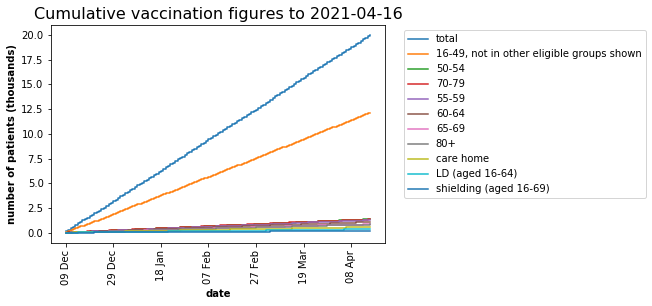

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [15]:
from report_results import summarise_data_by_group

In [16]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [17]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [18]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [19]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [20]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

In [21]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)))    
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 16 Apr 2021,second dose as at 16 Apr 2021
Total vaccinated in TPP,"19,999","4,998"
80+,"40.7% (833 of 2,044)","10.4% (210 of 2,044)"
70-79,"39.4% (1,351 of 3,437)","9.0% (308 of 3,437)"
care home,"40.0% (553 of 1,386)","10.2% (140 of 1,386)"
shielding (aged 16-69),41.5% (182 of 434),9.9% (42 of 434)
65-69,"39.3% (861 of 2,184)","9.5% (210 of 2,184)"
LD (aged 16-64),41.6% (343 of 826),7.9% (63 of 826)
60-64,"39.7% (1,078 of 2,716)","9.5% (259 of 2,716)"
55-59,"39.8% (1,267 of 3,192)","9.8% (315 of 3,192)"
50-54,"40.5% (1,379 of 3,402)","10.9% (371 of 3,402)"


*
 figures rounded to nearest 7

In [22]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Second doses (% of all vaccinated): **25.0%** (4,998)

Oxford-AZ vaccines (% of all first doses): **0.0%** (0)

Moderna vaccines (% of all first doses): **0.0%** (7)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [23]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout among **80+** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     831   
sex                       F                                           406   
                          M                                           427   
ageband_5yr               0                                            49   
                          0-15                                         49   
                          16-29                                        56   
                          30-34                                        56   
                          35-39                                        42   
                          40-44                                        63   
                          45-49                                        56   
                          50-54                                        42   
                          55-59                                        49   
                          60-64                                        56   
                          65-69                                        42   
                          70-74                                        63   
                          75-79                                        49   
                          80-84                                        56   
                          85-89                                        56   
                          90+                                          42   
ethnicity_6_groups        Black                                       154   
                          Mixed                                       147   
                          Other                                       133   
                          South Asian                                 126   
                          Unknown                                     133   
                          White                                       147   
ethnicity_16_groups        African                                     49   
                           Bangladeshi or British Bangladeshi          56   
                           Caribbean                                   49   
                           Chinese                                     35   
                           Other                                       42   
                           Other Asian                                 49   
                          British or Mixed British                     42   
                          Indian or British Indian                     42   
                          Irish                                        35   
                          Other Black                                  42   
                          Other White                                  42   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               49   
                          Unknown                                     119   
                          White + Asian                                35   
                          White + Black African                        42   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             175   
                          2                                           140   
                          3                                           154   
                          4                                           168   
                          5 Least deprived                            154   
                          Unknown                                      42   
bmi                       30+                                         231   
                          under 30                                    602   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout among **70-79** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1354   
sex                       F                                           693   
                          M                                           658   
ageband_5yr               0                                            84   
                          0-15                                         70   
                          16-29                                        84   
                          30-34                                        91   
                          35-39                                        98   
                          40-44                                        91   
                          45-49                                        98   
                          50-54                                        70   
                          55-59                                        84   
                          60-64                                        77   
                          65-69                                        84   
                          70-74                                        91   
                          75-79                                        84   
                          80-84                                        77   
                          85-89                                        84   
                          90+                                          91   
ethnicity_6_groups        Black                                       231   
                          Mixed                                       217   
                          Other                                       217   
                          South Asian                                 245   
                          Unknown                                     203   
                          White                                       238   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   84   
                           Chinese                                     70   
                           Other                                       84   
                           Other Asian                                 70   
                          British or Mixed British                     63   
                          Indian or British Indian                     77   
                          Irish                                        77   
                          Other Black                                  56   
                          Other White                                  56   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               77   
                          Unknown                                     217   
                          White + Asian                                77   
                          White + Black African                        77   
                          White + Black Caribbean                      56   
imd_categories            1 Most deprived                             252   
                          2                                           259   
                          3                                           259   
                          4                                           259   
                          5 Least deprived                            245   
                          Unknown                                      77   
bmi                       30+                                         427   
                          under 30                                    924   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout among **care home** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             555     40.0   1386   
sex                F                   280     38.5    728   
                   M                   280     42.6    658   
ageband_5yr        0                    56     50.0    112   
                   0-15                 35     45.5     77   
                   16-29                35     38.5     91   
                   30-34                35     41.7     84   
                   35-39                35     35.7     98   
                   40-44                35     41.7     84   
                   45-49                35     38.5     91   
                   50-54                35     41.7     84   
                   55-59                21     33.3     63   
                   60-64                28     33.3     84   
                   65-69                35     38.5     91   
                   70-74                35     41.7     84   
                   75-79                42     46.2     91   
                   80-84                28     33.3     84   
                   85-89                35     45.5     77   
                   90+                  35     45.5     77   
ethnicity_6_groups Black                84     34.3    245   
                   Mixed                98     41.2    238   
                   Other                91     39.4    231   
                   South Asian          98     43.8    224   
                   Unknown              84     40.0    210   
                   White                91     38.2    238   
dementia           no                  553     40.5   1365   
                   yes                   0      0.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 38.3   
sex                F                                       36.5   
                   M                                       40.4   
ageband_5yr        0                                       43.8   
                   0-15                                    45.5   
                   16-29                                   38.5   
                   30-34                                   41.7   
                   35-39                                   35.7   
                   40-44                                   41.7   
                   45-49                                   30.8   
                   50-54                                   41.7   
                   55-59                                   33.3   
                   60-64                                   33.3   
                   65-69                                   38.5   
                   70-74                                   41.7   
                   75-79                                   38.5   
                   80-84                                   33.3   
                   85-89                                   45.5   
                   90+                                     45.5   
ethnicity_6_groups Black                                   34.3   
                   Mixed                                   38.2   
                   Other                                   39.4   
                   South Asian                             40.6   
                   Unknown                                   40   
                   White                                   38.2   
dementia           no                                      38.5   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.7   
sex                F                                       2   
                   M             

## 

## COVID vaccination rollout among **shielding (aged 16-69)** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  180     41.5    434   
newly_shielded_since_feb_15 no                       175     41.0    427   
                            yes                        0      NaN      0   
sex                         F                         98     45.2    217   
                            M                         84     38.7    217   
ageband                     16-29                     14     28.6     49   
                            30-39                     21     37.5     56   
                            40-49                     28     57.1     49   
                            50-59                     28     57.1     49   
                            60-69                     21     33.3     63   
                            70-79                     42     35.3    119   
                            80+                       21     37.5     56   
ethnicity_6_groups          Black                     28     40.0     70   
                            Mixed                     35     45.5     77   
                            Other                     35     45.5     77   
                            South Asian               21     33.3     63   
                            Unknown                   28     40.0     70   
                            White                     35     50.0     70   
imd_categories              1 Most deprived           42     42.9     98   
                            2                         42     46.2     91   
                            3                         28     36.4     77   
                            4                         28     40.0     70   
                            5 Least deprived          28     40.0     70   
                            Unknown                   14     50.0     28   
LD                          no                       175     41.7    420   
                            yes                        0      0.0     14   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      38.2   
newly_shielded_since_feb_15 no                                           37.7   
                            yes                                           NaN   
sex                         F                                            41.9   
                            M                                            35.5   
ageband                     16-29                                        28.6   
                            30-39                                        37.5   
                            40-49                                        42.9   
                            50-59                                        57.1   
                            60-69                                        33.3   
                            70-79                                        29.4   
                            80+                                          37.5   
ethnicity_6_groups          Black                                          30   
                            Mixed                                        36.4   
                            Other                                        45.5   
                            South Asian                                  33.3   
                            Unknown                                        40   
                            White                                          40   
imd_categories              1 Most deprived                              42.9   
                            2                                            38.5   
                            3                                            36.4   
                            4                         

## 

## COVID vaccination rollout among **65-69** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     859   
sex                       F                                           434   
                          M                                           427   
ethnicity_6_groups        Black                                       140   
                          Mixed                                       140   
                          Other                                       154   
                          South Asian                                 154   
                          Unknown                                     140   
                          White                                       126   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   42   
                           Chinese                                     35   
                           Other                                       49   
                           Other Asian                                 42   
                          British or Mixed British                     42   
                          Indian or British Indian                     49   
                          Irish                                        56   
                          Other Black                                  42   
                          Other White                                  49   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               49   
                          Unknown                                     126   
                          White + Asian                                49   
                          White + Black African                        42   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             154   
                          2                                           182   
                          3                                           161   
                          4                                           147   
                          5 Least deprived                            154   
                          Unknown                                      56   
bmi                       30+                                         252   
                          under 30                                    609   
chronic_cardiac_disease   no                                          854   
                          yes                                           0   
current_copd              no                                          854   
                          yes                                           7   
dmards                    no                                          854   
                          yes                                           7   
dementia                  no                                          854   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          854   
                          yes                                           7   
LD                        no                                          847   
                          yes                                          14   
ssri                      no                                          847   
                          yes                                          14   
chemo_or_radio            no                                          847   
                          yes                                           7   
lung_cancer               no                               

## 

## COVID vaccination rollout among **LD (aged 16-64)** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             344     41.6    826   
sex                F                   182     40.6    448   
                   M                   161     42.6    378   
ageband_5yr        0                    14     40.0     35   
                   0-15                 28     50.0     56   
                   16-29                21     37.5     56   
                   30-34                21     42.9     49   
                   35-39                35     55.6     63   
                   40-44                21     37.5     56   
                   45-49                21     42.9     49   
                   50-54                21     42.9     49   
                   55-59                21     42.9     49   
                   60-64                21     37.5     56   
                   65-69                21     42.9     49   
                   70-74                21     42.9     49   
                   75-79                21     50.0     42   
                   80-84                21     42.9     49   
                   85-89                28     50.0     56   
                   90+                  21     37.5     56   
ethnicity_6_groups Black                56     40.0    140   
                   Mixed                63     47.4    133   
                   Other                56     40.0    140   
                   South Asian          63     45.0    140   
                   Unknown              49     38.9    126   
                   White                63     40.9    154   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 39.6   
sex                F                                       39.1   
                   M                                       40.7   
ageband_5yr        0                                         40   
                   0-15                                    37.5   
                   16-29                                     25   
                   30-34                                   42.9   
                   35-39                                   44.4   
                   40-44                                   37.5   
                   45-49                                   28.6   
                   50-54                                   42.9   
                   55-59                                   28.6   
                   60-64                                   37.5   
                   65-69                                   42.9   
                   70-74                                   42.9   
                   75-79                                     50   
                   80-84                                   42.9   
                   85-89                                     50   
                   90+                                     37.5   
ethnicity_6_groups Black                                     35   
                   Mixed                                   47.4   
                   Other                                     35   
                   South Asian                               45   
                   Unknown                                 33.3   
                   White                                   36.4   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                                 2   
sex                F                                     1.5   
                   M                                     1.9   
ageband_5yr        0                                       0   
                   0-15                                 12.5   
                   16-29                                12.5   
                   30-34           

## 

## COVID vaccination rollout among **60-64** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1079   
sex                       F                                           546   
                          M                                           532   
ethnicity_6_groups        Black                                       175   
                          Mixed                                       175   
                          Other                                       175   
                          South Asian                                 182   
                          Unknown                                     168   
                          White                                       210   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   84   
                           Chinese                                     49   
                           Other                                       49   
                           Other Asian                                 77   
                          British or Mixed British                     42   
                          Indian or British Indian                     49   
                          Irish                                        56   
                          Other Black                                  77   
                          Other White                                  63   
                          Other mixed                                  49   
                          Pakistani or British Pakistani               70   
                          Unknown                                     133   
                          White + Asian                                56   
                          White + Black African                        56   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             210   
                          2                                           210   
                          3                                           210   
                          4                                           189   
                          5 Least deprived                            217   
                          Unknown                                      42   
bmi                       30+                                         329   
                          under 30                                    749   
chronic_cardiac_disease   no                                         1064   
                          yes                                          14   
current_copd              no                                         1071   
                          yes                                           7   
dmards                    no                                         1071   
                          yes                                           7   
dementia                  no                                         1057   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         1071   
                          yes                                           7   
ssri                      no                                         1064   
                          yes                                          14   
chemo_or_radio            no                                         1064   
                          yes                                          14   
lung_cancer               no                                         1064   
                          yes                                          14   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout among **55-59** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1270   
sex                     F                                           637   
                        M                                           630   
ethnicity_6_groups      Black                                       224   
                        Mixed                                       210   
                        Other                                       203   
                        South Asian                                 196   
                        Unknown                                     217   
                        White                                       224   
ethnicity_16_groups      African                                     70   
                         Bangladeshi or British Bangladeshi          56   
                         Caribbean                                   70   
                         Chinese                                     77   
                         Other                                       77   
                         Other Asian                                 70   
                        British or Mixed British                     70   
                        Indian or British Indian                     63   
                        Irish                                        63   
                        Other Black                                  63   
                        Other White                                  77   
                        Other mixed                                  63   
                        Pakistani or British Pakistani               63   
                        Unknown                                     196   
                        White + Asian                                63   
                        White + Black African                        56   
                        White + Black Caribbean                      56   
imd_categories          1 Most deprived                             252   
                        2                                           238   
                        3                                           245   
                        4                                           231   
                        5 Least deprived                            252   
                        Unknown                                      63   
bmi                     30+                                         371   
                        under 30                                    896   
chronic_cardiac_disease no                                         1260   
                        yes                                          14   
current_copd            no                                         1253   
                        yes                                          14   
dmards                  no                                         1260   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1260   
                        yes                                           7   
ssri                    no                                         1253   
                        yes                                          14   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 39.8   3192   
sex                     F                                       38.7   1645   
                        M                                       40.7   1547   
ethnicity_6_groups      Black                                   41.0    546   
                        Mixed                                   38.5    546   
                        Other                            

## 

## COVID vaccination rollout among **50-54** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1378   
sex                     F                                           665   
                        M                                           707   
ethnicity_6_groups      Black                                       245   
                        Mixed                                       245   
                        Other                                       245   
                        South Asian                                 238   
                        Unknown                                     189   
                        White                                       210   
ethnicity_16_groups      African                                     77   
                         Bangladeshi or British Bangladeshi          70   
                         Caribbean                                   70   
                         Chinese                                     63   
                         Other                                       77   
                         Other Asian                                 77   
                        British or Mixed British                     70   
                        Indian or British Indian                     70   
                        Irish                                        77   
                        Other Black                                  77   
                        Other White                                  77   
                        Other mixed                                  70   
                        Pakistani or British Pakistani               70   
                        Unknown                                     217   
                        White + Asian                                63   
                        White + Black African                        84   
                        White + Black Caribbean                      77   
imd_categories          1 Most deprived                             259   
                        2                                           238   
                        3                                           245   
                        4                                           280   
                        5 Least deprived                            280   
                        Unknown                                      77   
bmi                     30+                                         399   
                        under 30                                    980   
chronic_cardiac_disease no                                         1365   
                        yes                                          14   
current_copd            no                                         1372   
                        yes                                           7   
dmards                  no                                         1365   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1358   
                        yes                                          21   
ssri                    no                                         1365   
                        yes                                          14   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 40.5   3402   
sex                     F                                       38.8   1715   
                        M                                       41.9   1687   
ethnicity_6_groups      Black                                   41.7    588   
                        Mixed                                   40.2    609   
                        Other                            

## 

## COVID vaccination rollout among **16-49, not in other eligible groups shown** population up to 16 Apr 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                   12150   
sex                     F                                          6223   
                        M                                          5929   
ageband                 16-29                                      1512   
                        30-39                                      1512   
                        40-49                                      1512   
                        50-59                                      1589   
                        60-69                                      1505   
                        70-79                                      2982   
                        80+                                        1540   
ethnicity_6_groups      Black                                      1995   
                        Mixed                                      2107   
                        Other                                      2121   
                        South Asian                                2135   
                        Unknown                                    1792   
                        White                                      2002   
ethnicity_16_groups      African                                    637   
                         Bangladeshi or British Bangladeshi         651   
                         Caribbean                                  672   
                         Chinese                                    672   
                         Other                                      658   
                         Other Asian                                630   
                        British or Mixed British                    637   
                        Indian or British Indian                    672   
                        Irish                                       665   
                        Other Black                                 651   
                        Other White                                 602   
                        Other mixed                                 616   
                        Pakistani or British Pakistani              616   
                        Unknown                                    1813   
                        White + Asian                               672   
                        White + Black African                       658   
                        White + Black Caribbean                     623   
imd_categories          1 Most deprived                            2296   
                        2                                          2345   
                        3                                          2296   
                        4                                          2254   
                        5 Least deprived                           2331   
                        Unknown                                     623   
bmi                     30+                                        3647   
                        under 30                                   8505   
chronic_cardiac_disease no                                        12019   
                        yes                                         126   
current_copd            no                                        12019   
                        yes                                         126   
dmards                  no                                        12033   
                        yes                                         119   
ssri                    no                                        12033   
                        yes                                         119   

                                                            vaccinated 7d previous  \
category                group                                                        
overall                 overall                                

# Demographics time trend charts

In [24]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 16 Apr 2021

###  COVID vaccinations among **80+** population by **sex**

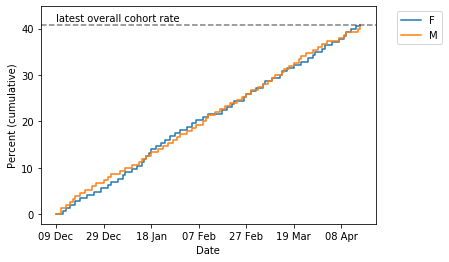

###  COVID vaccinations among **80+** population by **ageband 5yr**

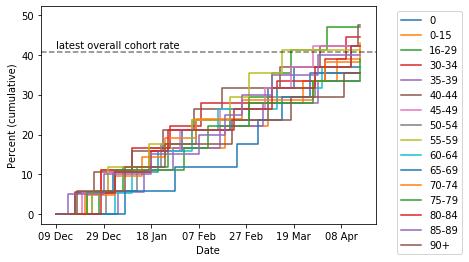

###  COVID vaccinations among **80+** population by **ethnicity 6 groups**

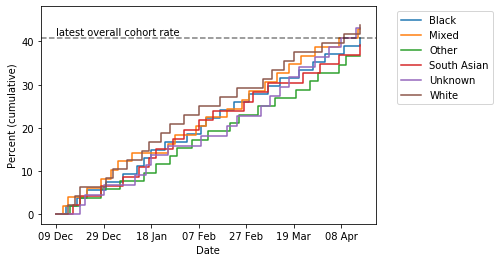

###  COVID vaccinations among **80+** population by **imd categories**

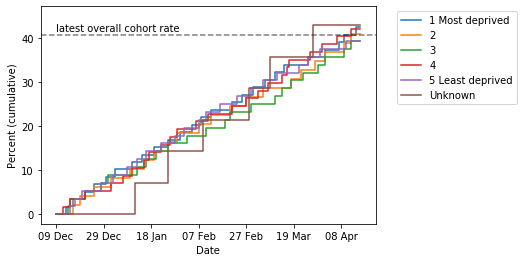

###  COVID vaccinations among **80+** population by **bmi**

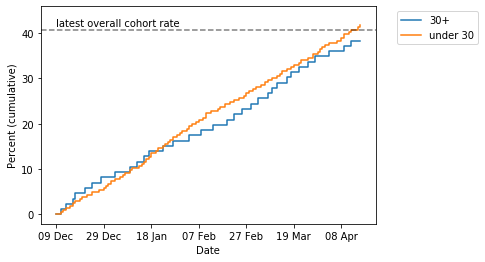

###  COVID vaccinations among **80+** population by **chronic cardiac disease**

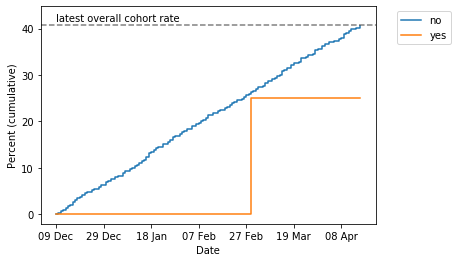

###  COVID vaccinations among **80+** population by **current copd**

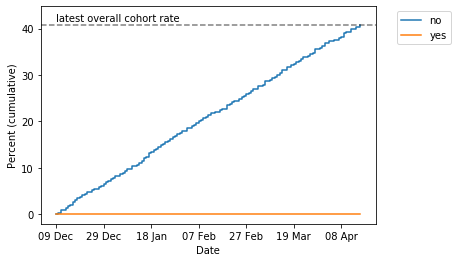

###  COVID vaccinations among **80+** population by **dialysis**

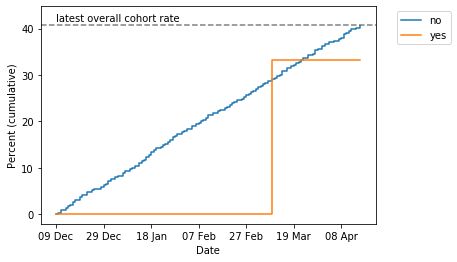

###  COVID vaccinations among **80+** population by **dementia**

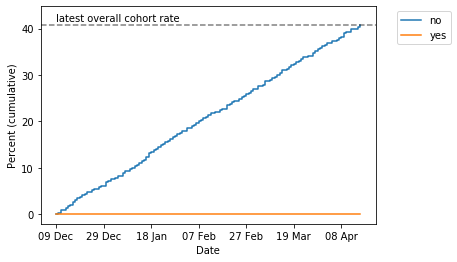

###  COVID vaccinations among **80+** population by **psychosis schiz bipolar**

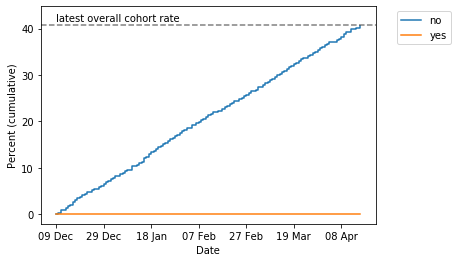

###  COVID vaccinations among **80+** population by **LD**

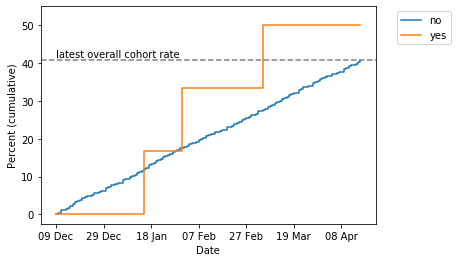

###  COVID vaccinations among **80+** population by **ssri**

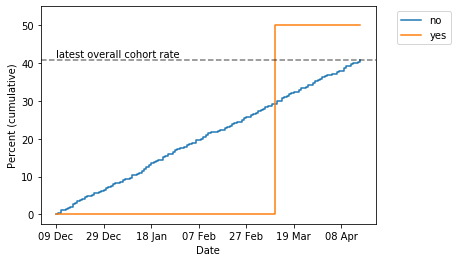

## 
 ## COVID vaccination rollout among **70-79** population up to 16 Apr 2021

###  COVID vaccinations among **70-79** population by **sex**

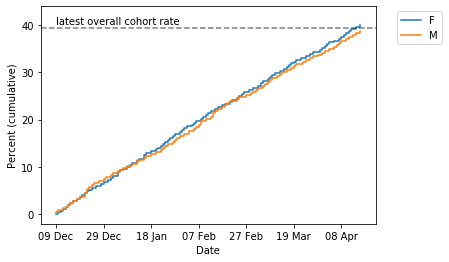

###  COVID vaccinations among **70-79** population by **ageband 5yr**

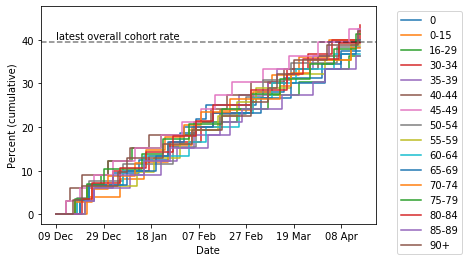

###  COVID vaccinations among **70-79** population by **ethnicity 6 groups**

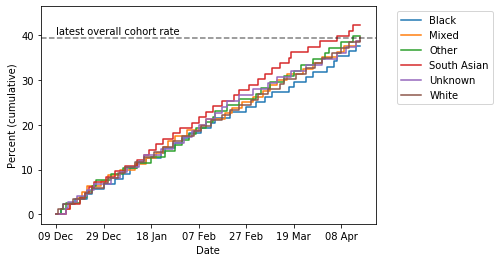

###  COVID vaccinations among **70-79** population by **imd categories**

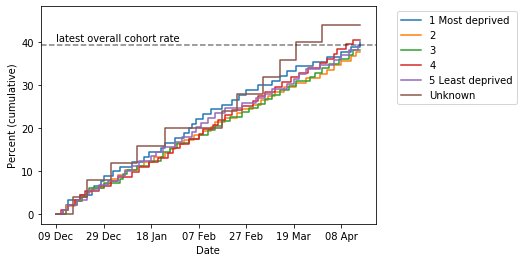

###  COVID vaccinations among **70-79** population by **bmi**

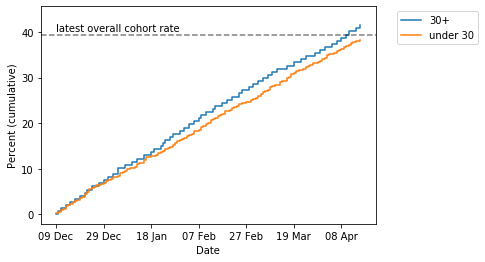

###  COVID vaccinations among **70-79** population by **chronic cardiac disease**

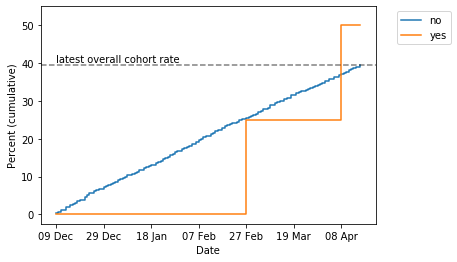

###  COVID vaccinations among **70-79** population by **current copd**

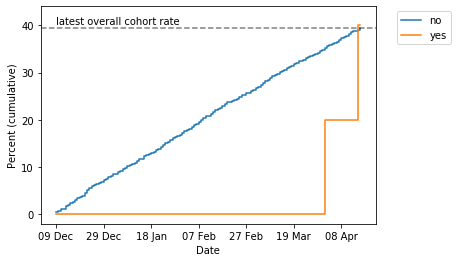

###  COVID vaccinations among **70-79** population by **dialysis**

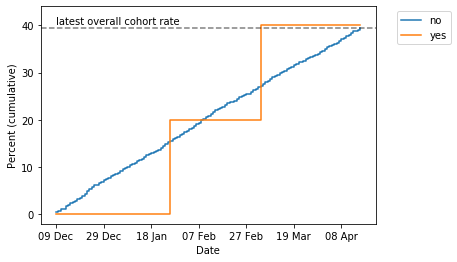

###  COVID vaccinations among **70-79** population by **dementia**

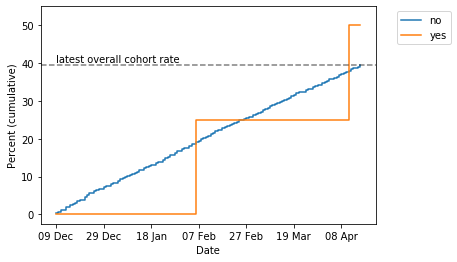

###  COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

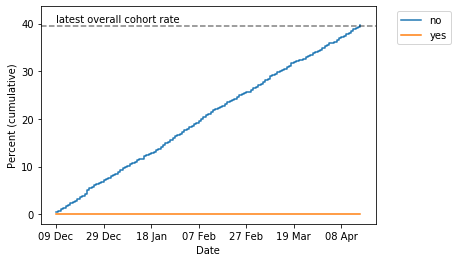

###  COVID vaccinations among **70-79** population by **LD**

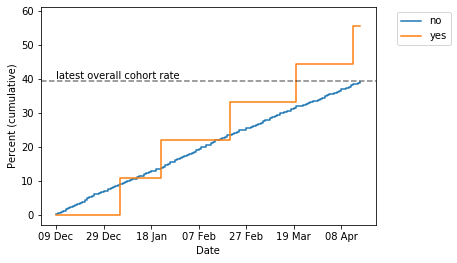

###  COVID vaccinations among **70-79** population by **ssri**

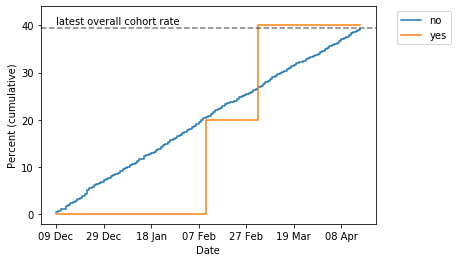

## 
 ## COVID vaccination rollout among **65-69** population up to 16 Apr 2021

###  COVID vaccinations among **65-69** population by **sex**

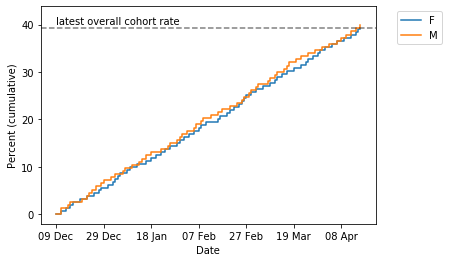

###  COVID vaccinations among **65-69** population by **ethnicity 6 groups**

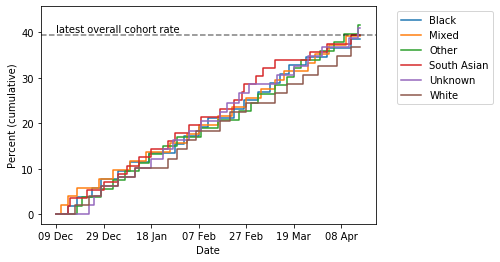

###  COVID vaccinations among **65-69** population by **imd categories**

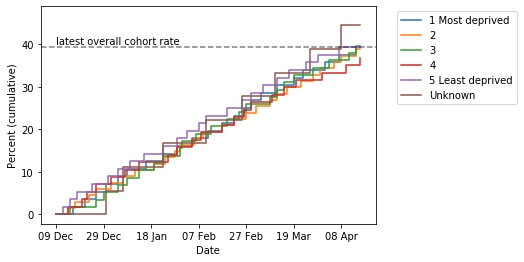

###  COVID vaccinations among **65-69** population by **bmi**

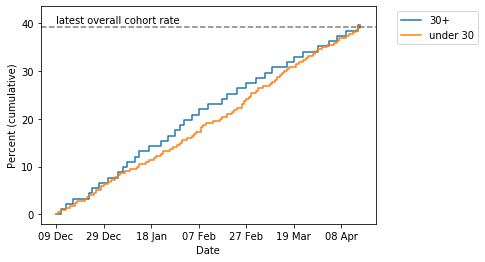

###  COVID vaccinations among **65-69** population by **chronic cardiac disease**

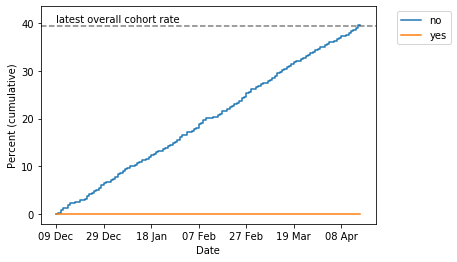

###  COVID vaccinations among **65-69** population by **current copd**

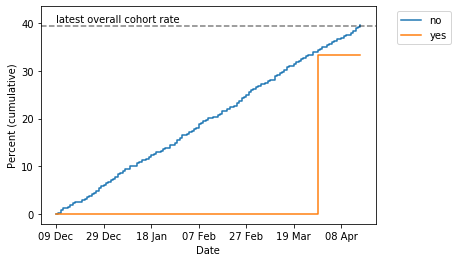

###  COVID vaccinations among **65-69** population by **dementia**

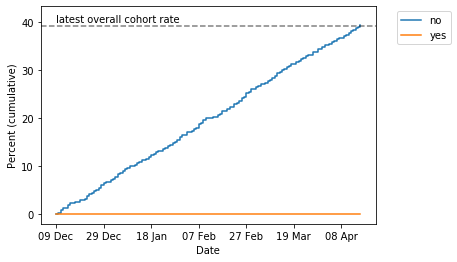

###  COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

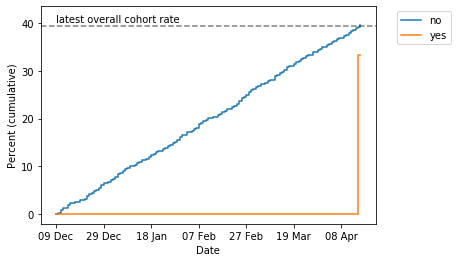

###  COVID vaccinations among **65-69** population by **LD**

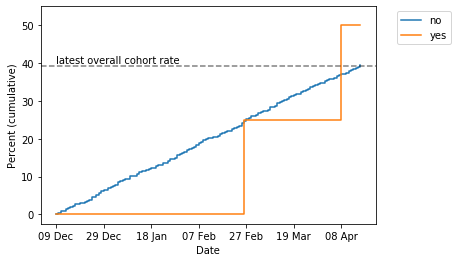

###  COVID vaccinations among **65-69** population by **ssri**

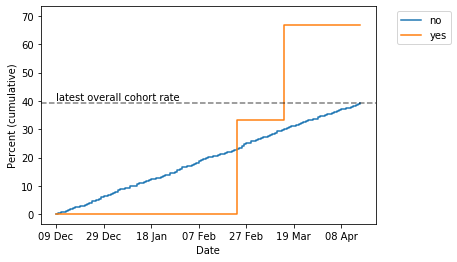

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 16 Apr 2021

###  COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

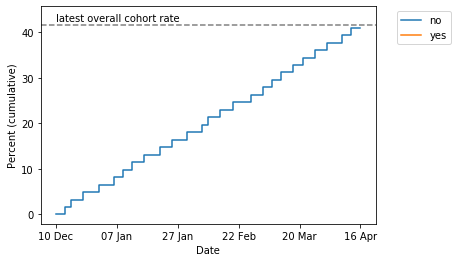

###  COVID vaccinations among **shielding (aged 16-69)** population by **sex**

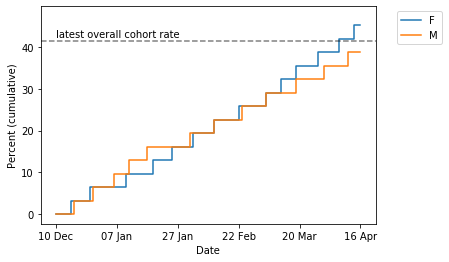

###  COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

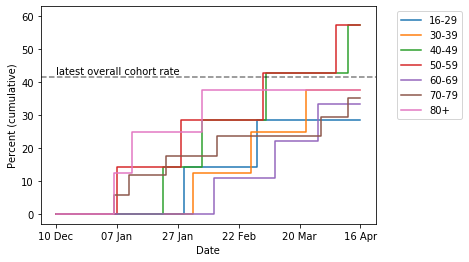

###  COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

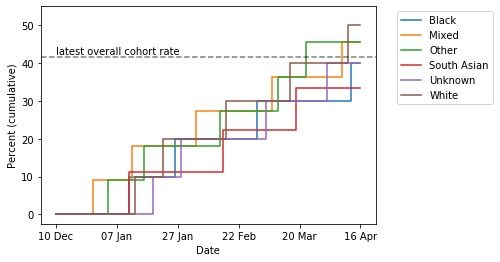

###  COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

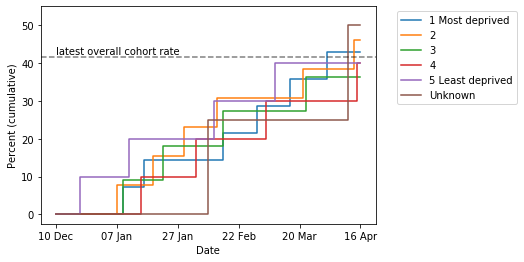

###  COVID vaccinations among **shielding (aged 16-69)** population by **LD**

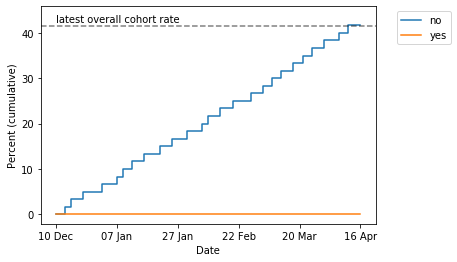

## 
 ## COVID vaccination rollout among **60-64** population up to 16 Apr 2021

###  COVID vaccinations among **60-64** population by **sex**

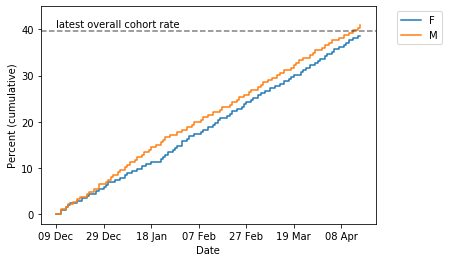

###  COVID vaccinations among **60-64** population by **ethnicity 6 groups**

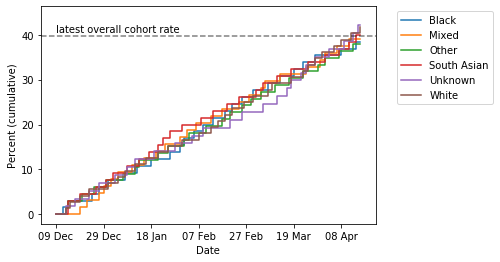

###  COVID vaccinations among **60-64** population by **imd categories**

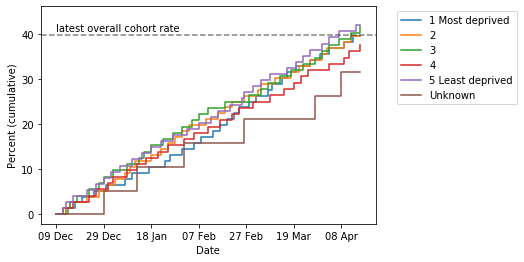

###  COVID vaccinations among **60-64** population by **bmi**

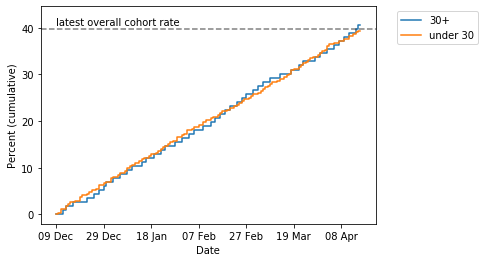

###  COVID vaccinations among **60-64** population by **chronic cardiac disease**

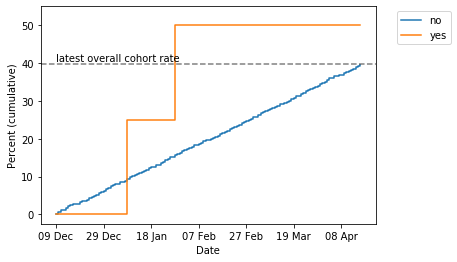

###  COVID vaccinations among **60-64** population by **current copd**

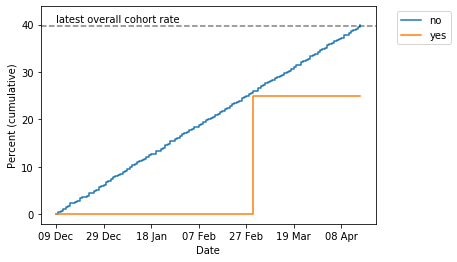

###  COVID vaccinations among **60-64** population by **dementia**

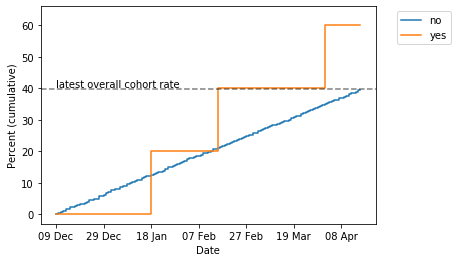

###  COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

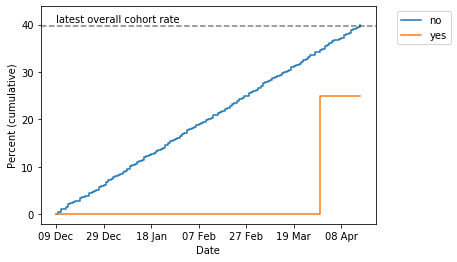

###  COVID vaccinations among **60-64** population by **ssri**

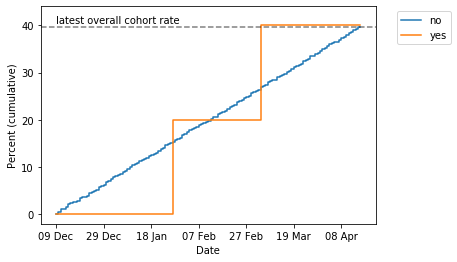

## 
 ## COVID vaccination rollout among **55-59** population up to 16 Apr 2021

###  COVID vaccinations among **55-59** population by **sex**

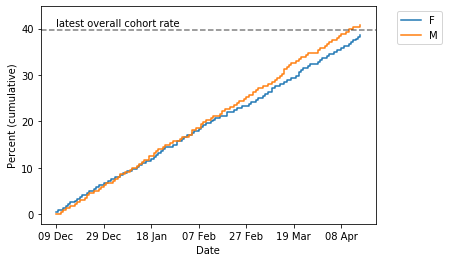

###  COVID vaccinations among **55-59** population by **ethnicity 6 groups**

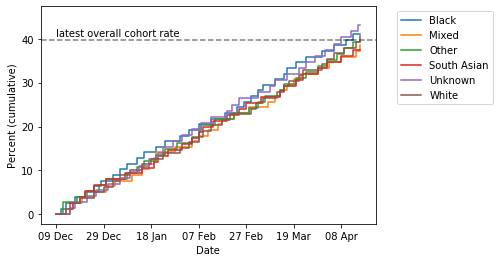

###  COVID vaccinations among **55-59** population by **imd categories**

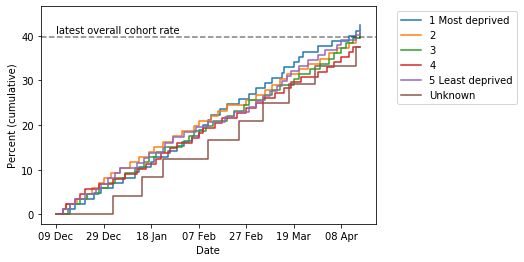

###  COVID vaccinations among **55-59** population by **bmi**

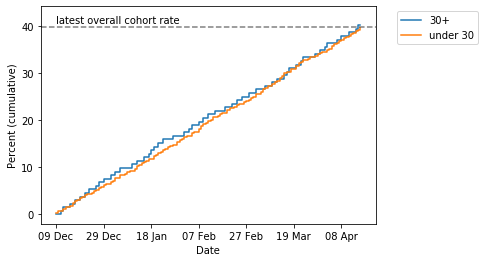

###  COVID vaccinations among **55-59** population by **chronic cardiac disease**

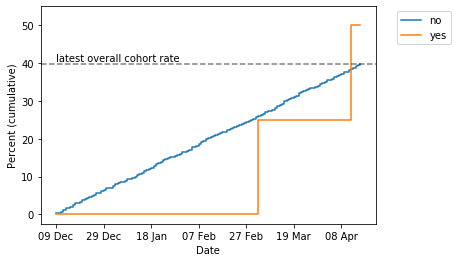

###  COVID vaccinations among **55-59** population by **current copd**

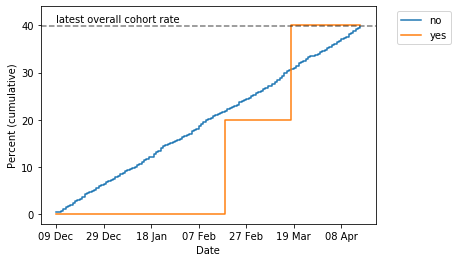

###  COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

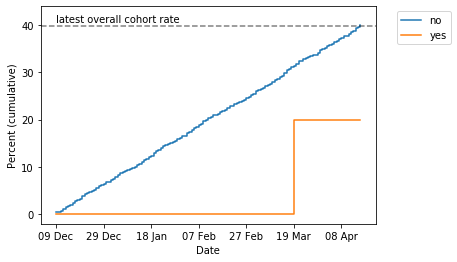

###  COVID vaccinations among **55-59** population by **ssri**

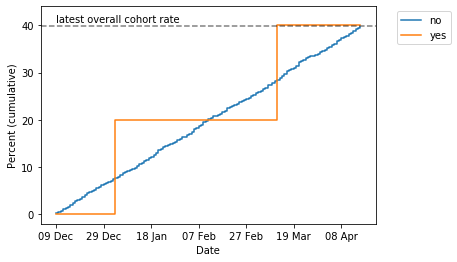

## 
 ## COVID vaccination rollout among **50-54** population up to 16 Apr 2021

###  COVID vaccinations among **50-54** population by **sex**

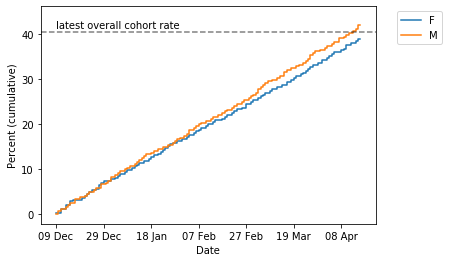

###  COVID vaccinations among **50-54** population by **ethnicity 6 groups**

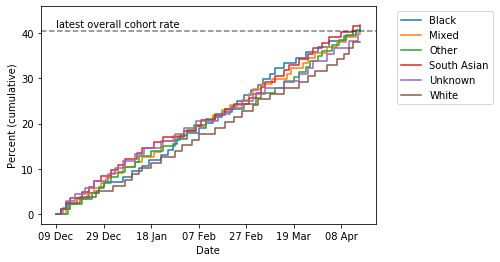

###  COVID vaccinations among **50-54** population by **imd categories**

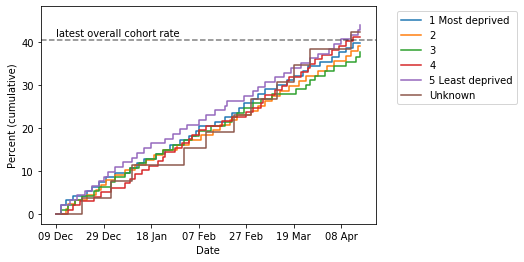

###  COVID vaccinations among **50-54** population by **bmi**

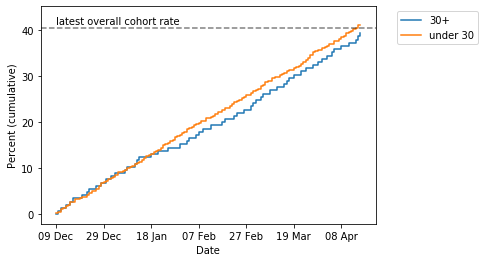

###  COVID vaccinations among **50-54** population by **chronic cardiac disease**

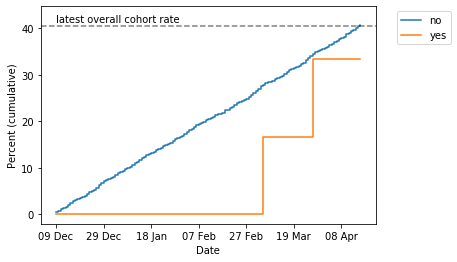

###  COVID vaccinations among **50-54** population by **current copd**

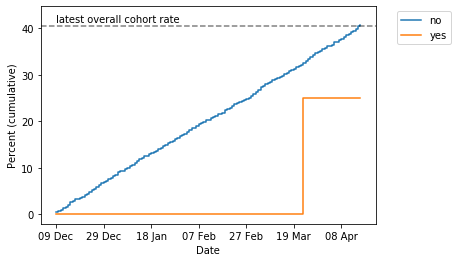

###  COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

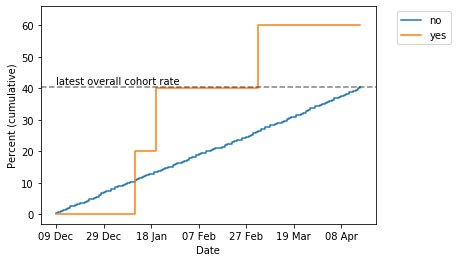

###  COVID vaccinations among **50-54** population by **ssri**

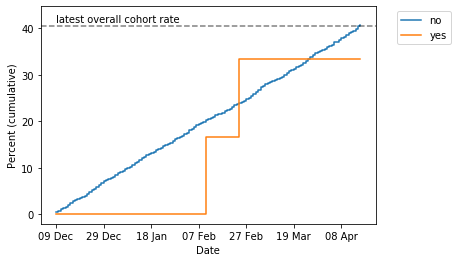

In [25]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [26]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,743 (85.3%)

Total **70-79** population with ethnicity recorded 2,905 (84.5%)

Total **care home** population with ethnicity recorded 1,176 (84.8%)

Total **shielding (aged 16-69)** population with ethnicity recorded 357 (82.3%)

Total **65-69** population with ethnicity recorded 1,834 (84.0%)

Total **LD (aged 16-64)** population with ethnicity recorded 707 (85.6%)

Total **60-64** population with ethnicity recorded 2,317 (85.3%)

Total **55-59** population with ethnicity recorded 2,688 (84.2%)

Total **50-54** population with ethnicity recorded 2,926 (86.0%)

Total **vaccinated 16-49, not in other eligible groups shown** population with ethnicity recorded 25,809 (85.0%)